In [13]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [14]:
from models import MLP_PINN
net = MLP_PINN(N_layers=8, width=32, activation=nn.Softplus(30), last_activation=nn.Softplus(30)).to(device)
net.loss_lambda['loss_normal'] = 0.1
net.loss_lambda['loss_cosine_similarity'] = 0.1
net.loss_lambda['loss_residual'] = 0.1
net.loss_lambda['loss_residual_constraint'] = 0.1

In [15]:
import os
from utils.dataset_generator import ImplicitDataset, batch_loader

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)

# filter out discontinous points
grads = train_dataset.grads
norm_grad = torch.linalg.norm(grads, dim=1)
mark = torch.logical_and(norm_grad > 0.9, norm_grad < 1.001)
train_dataset.grads = grads[mark]
train_dataset.points = train_dataset.points[mark]
train_dataset.sdfs = train_dataset.sdfs[mark]
# train_dataset.points.requires_grad_(True)

print(train_dataset)
residual_points = train_dataset.points.clone()

ImplicitDataset (42282 points)


In [16]:
from utils.callback_scheduler import CallbackScheduler
from utils.residual_sampler import ResidualSampler

# Residual Sampler initialzation
residual_sampler = ResidualSampler(net, num_grid_points=100*100*100)
residual_sampler.set_bounds_from_points(train_dataset.points)

# Optimizer initialization
torch.nn.utils.clip_grad_norm_(net.parameters(), 10.0)
optimizer=torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.nothing(),
    CallbackScheduler.nothing(),
    CallbackScheduler.adaptive_residual_sampling(num_points=10000),
    CallbackScheduler.adaptive_residual_sampling(num_points=10000, expand_scale_ratio=0.5),
    CallbackScheduler.adaptive_residual_sampling(num_points=10000),
    CallbackScheduler.adaptive_residual_sampling(num_points=10000, expand_scale_ratio=0.5),
    CallbackScheduler.adaptive_residual_sampling(num_points=10000),
], optimizer=optimizer, residual_points=residual_points, residual_sampler=residual_sampler, model=net, eps=1e-7, patience=300)

In [17]:
from math import ceil

batch_size = len(train_dataset.points)
lr_step = 500

LR_CALLBACK_EVERY_EPOCH = int(lr_step * ceil(len(train_dataset.points) / batch_size))
MAX_EPOCHS = int(LR_CALLBACK_EVERY_EPOCH * (len(lr_scheduler)+1))
PRINT_EVERY_EPOCH = int(MAX_EPOCHS // 10)

print(f'Max epoch: {MAX_EPOCHS} (PRINT: {PRINT_EVERY_EPOCH}, CALLBACK: {LR_CALLBACK_EVERY_EPOCH})')

try:
    epoch = 0
    while epoch < MAX_EPOCHS:
        for points, sdfs in batch_loader(train_dataset.points, train_dataset.sdfs, batch_size=batch_size):
            # Training
            if not points.requires_grad:
                points.requires_grad_(True)
            if not lr_scheduler.residual_points.requires_grad:
                lr_scheduler.residual_points.requires_grad_(True)
            lr_scheduler.optimizer.zero_grad()
            loss = net.loss(points, sdfs, lr_scheduler.residual_points)
            loss.backward()
            lr_scheduler.optimizer.step(lambda: loss)
            
            lr_scheduler.step_when((epoch % LR_CALLBACK_EVERY_EPOCH) == LR_CALLBACK_EVERY_EPOCH - 1, verbose=True)
            if epoch % PRINT_EVERY_EPOCH == 0:
                print(f'#{epoch} {net.print_loss()}')

            epoch += 1
    print(f'#{epoch}\nSuccess')
except KeyboardInterrupt as e:
    print('Bye bye')



Max epoch: 4000 (PRINT: 400, CALLBACK: 500)
#0 Loss: 0.023550 0.993708 na na na 
#400 Loss: 0.007137 0.030016 na na na 
Learning rate changed
#800 Loss: 0.005004 0.029104 na na na 
Learning rate changed
#1200 Loss: 0.003945 0.019923 na na na 
Learning rate changed
#1600 Loss: 0.003208 0.019477 na na na 
Learning rate changed
#2000 Loss: 0.002917 0.022141 na na na 
#2400 Loss: 0.002768 0.017828 na na na 
Learning rate changed
#2800 Loss: 0.002512 0.017054 na na na 
Learning rate changed
#3200 Loss: 0.002232 0.018757 na na na 
Learning rate changed
#3600 Loss: 0.002162 0.013800 na na na 
Learning rate changed
#4000
Success


In [6]:
#torch.save(net.state_dict(), f'{dataset_name}-PINN.pth')

In [19]:
net.load_state_dict(torch.load('./MLP_5000.pth'))

RuntimeError: Error(s) in loading state_dict for MLP_PINN:
	size mismatch for model.0.weight: copying a param with shape torch.Size([28, 3]) from checkpoint, the shape in current model is torch.Size([32, 3]).
	size mismatch for model.0.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.2.weight: copying a param with shape torch.Size([28, 28]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for model.2.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.4.weight: copying a param with shape torch.Size([28, 28]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for model.4.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.6.weight: copying a param with shape torch.Size([28, 28]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for model.6.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.8.weight: copying a param with shape torch.Size([28, 28]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for model.8.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.10.weight: copying a param with shape torch.Size([28, 28]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for model.10.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.12.weight: copying a param with shape torch.Size([28, 28]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for model.12.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.14.weight: copying a param with shape torch.Size([28, 28]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for model.14.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.16.weight: copying a param with shape torch.Size([28, 28]) from checkpoint, the shape in current model is torch.Size([32, 32]).
	size mismatch for model.16.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.18.weight: copying a param with shape torch.Size([1, 28]) from checkpoint, the shape in current model is torch.Size([1, 32]).

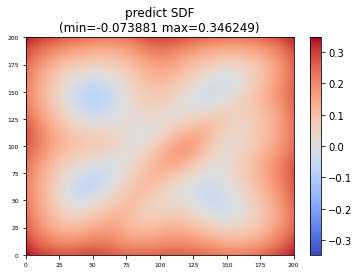

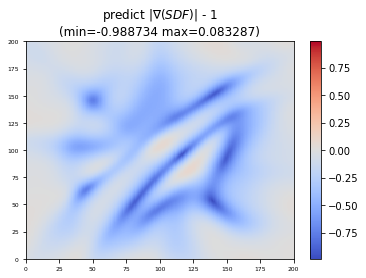

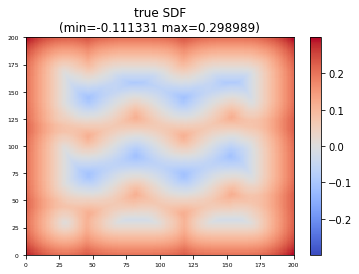

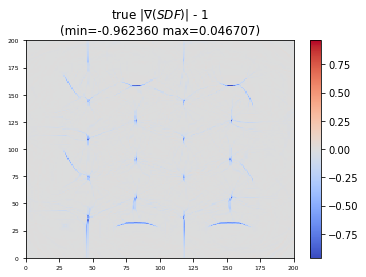

In [18]:
from utils.visualizer import SDFVisualize
net.to(device)
visualize = SDFVisualize(z_level=0.0, scale_offset=0.2, nums=200, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)

In [33]:
from utils.dataset_generator import TestDataset, run_batch
test_dataset = TestDataset(dataset_name+'_test.npz', device=device)
kwarg = {'reducer': torch.mean, 'batch_size': 10000}
#print('Train residual: ', net.test_residual(train_dataset.points).cpu().detach().numpy())
print('Test uniform SDFS: ', run_batch(net.test, test_dataset.uniform.points, test_dataset.uniform.sdfs, **kwarg).cpu().detach().numpy())
print('Test uniform residual:', run_batch(net.test_residual, test_dataset.uniform.points, **kwarg).cpu().detach().numpy())
print('Test uniform norm grads: ', run_batch(net.test_norm_gradient, test_dataset.uniform.points, test_dataset.uniform.norm_grads, **kwarg).cpu().detach().numpy())
print('Test random SDFS: ', run_batch(net.test, test_dataset.random.points, test_dataset.random.sdfs, **kwarg).cpu().detach().numpy())
print('Test random residual: ', run_batch(net.test_residual, test_dataset.random.points, **kwarg).cpu().detach().numpy())
#print('Actual uniform residual: ', torch.mean((test_dataset.uniform.gradients - 1)**2).cpu().detach().numpy())

Uniform SDFS:  9.662179e-05
Uniform gradient:  0.026583994
Random SDFS: 0.00025334614
Outside SDFS: 0.10373663
